## Prep

In [186]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [187]:
%cd drive/My Drive/Master Thesis 2020

[Errno 2] No such file or directory: 'drive/My Drive/Master Thesis 2020'
/content/drive/My Drive/Master Thesis 2020


In [188]:
!ls

 0000012746_mid_2016.csv
 0000021865_mid_2018.csv
 0000023623_mid_2017.csv
 0000024416_mid_2019.csv
 0000026351_mid_2020.csv
'Actual Generation per Production Type_201601010000-201701010000.csv'
'Actual Generation per Production Type_201701010000-201801010000.csv'
'Actual Generation per Production Type_201801010000-201901010000.csv'
'Actual Generation per Production Type_201901010000-202001010000.csv'
 Code_Masterthesis.ipynb
 Code_Masterthesis_Jeffrey_Edited.ipynb
 Code_Masterthesis_Models.ipynb
 Code_Masterthesis_working.ipynb
 Confidential
 count_plot.png
'Data sets'
 debug.gdoc
 Draft
 elexon_all_uk.csv
 Elexon_demand_INDO.csv
 Elexon_demand_ITSDO.csv
 Elexon_imbalance_price.csv
 Elexon_intraday_price.csv
 Elexon_WINDFOR.csv
 Elexon_WINDGEN.csv
'Generation Forecasts for Wind and Solar_201601010000-201701010000.csv'
'Generation Forecasts for Wind and Solar_201701010000-201801010000.csv'
'Generation Forecasts for Wind and Solar_201801010000-201901010000.csv'
'Generation Forecasts for

In [189]:
import pandas as pd
import os
import numpy as np
import xlrd
import copy
import datetime
import glob
from __future__ import division, print_function, unicode_literals

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns; sns.set()
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

# To plot pretty figures
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rc("font", size=14)
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
%matplotlib inline

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [190]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_linear_models"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [191]:
# Reference
# https://nbviewer.jupyter.org/github/ageron/handson-ml/blob/master/04_training_linear_models.ipynb

#### Import data


In [192]:
df_uk_elewind = pd.read_csv('elexon_all_uk.csv', sep=',') # TO-DO: make sure the timeblokcs are continuous and with 30 min timeblocks
df_uk_elewind = df_uk_elewind.rename(columns={'Unnamed: 0': 'timeblock'}) # TO-DO: Feel in elexon wind for with mean...
df_uk_elewind['timeblock'] = pd.to_datetime(df_uk_elewind['timeblock'])
df_uk_elewind.set_index('timeblock', drop = True, inplace = True)
df_uk = df_uk_elewind # extra code
# df_uk.head()
# df_uk_elewind.index.dtype # '<M8[ns]'is time series

In [193]:
# Drop unwanted Elexon data & make timesereis as index
# df_uk = df_uk_elewind.drop(columns= ['wind_elexon', 'wind_for_elexon'])
df_uk.head()

,demand_ITSDO,demand_INDO,wind_elexon,wind_for_elexon,imbalance_price,imbalance_volume,solar,wind_total,wind_for_total,solar_for,intraday_volume,intraday_price
timeblock,,,,,,,,,,,,
2017-01-01 00:00:00,27949.0,27239.0,3923.1666666666665,2423.0,40.00000,-251.8659,0.0,4891.0,3140.0,0.0,505.00,44.90
2017-01-01 00:30:00,28435.0,27814.0,3657.5,2423.0,46.86500,26.7183,0.0,4595.0,3140.0,0.0,559.15,47.13
2017-01-01 01:00:00,28165.0,27453.0,3925.0,2528.5,40.24737,-93.0661,0.0,4686.0,3242.5,0.0,649.35,45.62
2017-01-01 01:30:00,27707.0,26312.0,4393.166666666667,2528.5,40.05000,-403.2791,0.0,5439.0,3242.5,0.0,712.65,44.05
2017-01-01 02:00:00,27449.0,25289.0,4417.666666666667,2538.0,40.01602,-447.9751,0.0,5400.0,3272.5,0.0,599.15,44.83


In [194]:
# Create new column y: intraday price - imbalance price >= 0  then denote as 1, intraday price - imbalance price <0 then denote as 0
# TO-DO: ROC curve https://www.google.com/url?sa=i&url=https%3A%2F%2Fmachinelearningmastery.com%2Froc-curves-and-precision-recall-curves-for-classification-in-python%2F&psig=AOvVaw0v5zXIpH4HfiuTZ-tlMgrC&ust=1595149731542000&source=images&cd=vfe&ved=0CAIQjRxqFwoTCOCF0e-51uoCFQAAAAAdAAAAABAD
# TO-DO: show how confident we should
# TO-DO: look at ARIMA
def create_y_column(row): # Alternative: where method
    if row['intraday_price'] < row['imbalance_price']: # Learning: Use lambda function
        val = 0
    else:
        val = 1

    return val

In [195]:
df_uk['y'] = df_uk.apply(create_y_column, axis=1)
# df_uk_elewind['y'] = df_uk_elewind.apply(create_y_column, axis=1)

In [196]:
df_uk.index

DatetimeIndex(['2017-01-01 00:00:00', '2017-01-01 00:30:00',
               '2017-01-01 01:00:00', '2017-01-01 01:30:00',
               '2017-01-01 02:00:00', '2017-01-01 02:30:00',
               '2017-01-01 03:00:00', '2017-01-01 03:30:00',
               '2017-01-01 04:00:00', '2017-01-01 04:30:00',
               ...
               '2019-12-31 19:00:00', '2019-12-31 19:30:00',
               '2019-12-31 20:00:00', '2019-12-31 20:30:00',
               '2019-12-31 21:00:00', '2019-12-31 21:30:00',
               '2019-12-31 22:00:00', '2019-12-31 22:30:00',
               '2019-12-31 23:00:00', '2019-12-31 23:30:00'],
              dtype='datetime64[ns]', name='timeblock', length=52566, freq=None)

In [197]:
df_uk.columns

Index(['demand_ITSDO', 'demand_INDO', 'wind_elexon', 'wind_for_elexon',
       'imbalance_price', 'imbalance_volume', 'solar', 'wind_total',
       'wind_for_total', 'solar_for', 'intraday_volume', 'intraday_price',
       'y'],
      dtype='object')

#### Is the target variable unbalanced due to numbers of 1 and 0?

In [198]:
df_uk['y'].value_counts() # not too bad

1    31497
0    21069
Name: y, dtype: int64

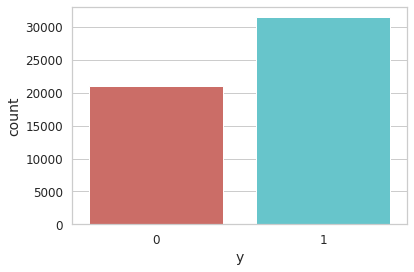

<Figure size 432x288 with 0 Axes>

In [199]:
sns.countplot(x='y', data=df_uk,palette='hls')
plt.show()
plt.savefig('count_plot')

In [200]:
count_smaller = len(df_uk[df_uk['y']==0])
count_bigger = len(df_uk[df_uk['y']==1])
pct_of_smaller = count_smaller/(count_smaller+count_bigger)
print("intraday price - imbalance price <0: ", pct_of_smaller*100)
pct_of_bigger = count_bigger/(count_smaller+count_bigger)
print("intraday price- imbalance price >= 0: ", pct_of_bigger*100)

intraday price - imbalance price <0:  40.08104097705741
intraday price- imbalance price >= 0:  59.91895902294259


#### Dimentionality reduction


##### High Correlation filter

In [201]:
# Lower the dimentation: Combine/pick one/ + / x, shall look online # To-Do: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html
# 10 varables -> 5 or 4 (optimal) # To-Do: What is the threshold? 0.6  # Akarsha's task THXXXXXX XXXXX # https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21
# If can't identify corr, then use e.g. PCA.

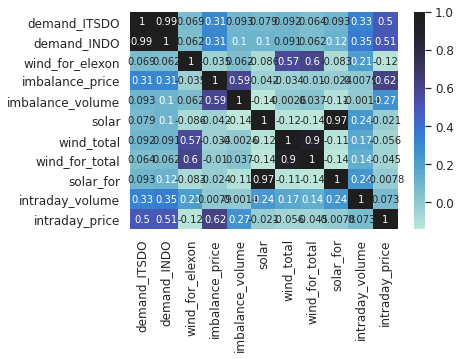

In [202]:
df_uk_elewind_x = df_uk_elewind.drop('y', 1) # where is wind elexon?
corrMatrix = df_uk_elewind_x.corr()
sns.heatmap(corrMatrix, annot=True, center=1) 
plt.show()
# (demand_ITSDO, demand_INDO) (solar_for, solar)  # TO-DO: threshold 80%, and take 60% -80% to do PCA and have new
# Select just one: (demand_ITSDO, demand_INDO) (wind_total, wind_for_total) (solar, solar_for) -> demand_INDO, wind_total, solar
# Use PCA: wind_total, wind_for_elexon, imbalance price, imbalance volume, intraday_price, imbalance volume, wind for total
  # -> wind_for_elexon, imbalance price, imbalance volume, intraday_price,  wind for total

In [203]:
df_uk_3var = df_uk[['demand_INDO', 'wind_total', 'solar']]
df_uk_3var

,demand_INDO,wind_total,solar
timeblock,,,
2017-01-01 00:00:00,27239.0,4891.0,0.0
2017-01-01 00:30:00,27814.0,4595.0,0.0
2017-01-01 01:00:00,27453.0,4686.0,0.0
2017-01-01 01:30:00,26312.0,5439.0,0.0
2017-01-01 02:00:00,25289.0,5400.0,0.0
...,...,...,...
2019-12-31 21:30:00,29172.0,5254.0,0.0
2019-12-31 22:00:00,28126.0,5567.0,0.0
2019-12-31 22:30:00,27407.0,5553.0,0.0


##### PCA

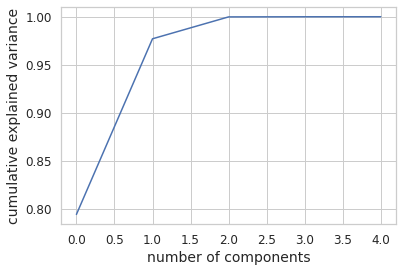

In [204]:
from sklearn.decomposition import PCA
df_uk_pca = df_uk[['imbalance_price', 'imbalance_volume','wind_for_total', 'wind_for_elexon', 'intraday_price']]

pca = PCA().fit(df_uk[['imbalance_price', 'imbalance_volume','wind_for_total', 'wind_for_elexon', 'intraday_price']])
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance'); # Interesting: add ; eliminates the test 
# Result: 2 components already explains 99% variance; 4 explains almost 100%

In [205]:
# Before starting the analysis, we need to standardize the values for PCA
from sklearn.preprocessing import StandardScaler 
features = [ # wind_for_elexon, imbalance price, imbalance volume, intraday_price,  wind for total
       'imbalance_price', 'imbalance_volume','wind_for_total',
       'wind_for_elexon', 'intraday_price']
# Separating out the features
x = df_uk.loc[:, features].values
# Separating out the target
y = df_uk.loc[:,['y']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

In [206]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc_1', 'pc_2']) # these can be the new attributes
principalDf.index = df_uk.index
principalDf

,pc_1,pc_2
timeblock,,
2017-01-01 00:00:00,-0.528806,-0.031950
2017-01-01 00:30:00,0.118386,0.119220
2017-01-01 01:00:00,-0.271481,0.139021
2017-01-01 01:30:00,-0.795801,-0.011947
2017-01-01 02:00:00,-0.839250,-0.019264
...,...,...
2019-12-31 21:30:00,-0.109031,0.450541
2019-12-31 22:00:00,-0.065824,0.490398
2019-12-31 22:30:00,-1.423609,0.299946


In [207]:
finalDf = pd.concat([principalDf, df_uk['y']], axis = 1)
finalDf # Solved: Why only NaN in y column & many NaN in last rows in other columns? -> due to wrong indexing above

,pc_1,pc_2,y
timeblock,,,
2017-01-01 00:00:00,-0.528806,-0.031950,1
2017-01-01 00:30:00,0.118386,0.119220,1
2017-01-01 01:00:00,-0.271481,0.139021,1
2017-01-01 01:30:00,-0.795801,-0.011947,1
2017-01-01 02:00:00,-0.839250,-0.019264,1
...,...,...,...
2019-12-31 21:30:00,-0.109031,0.450541,0
2019-12-31 22:00:00,-0.065824,0.490398,0
2019-12-31 22:30:00,-1.423609,0.299946,1


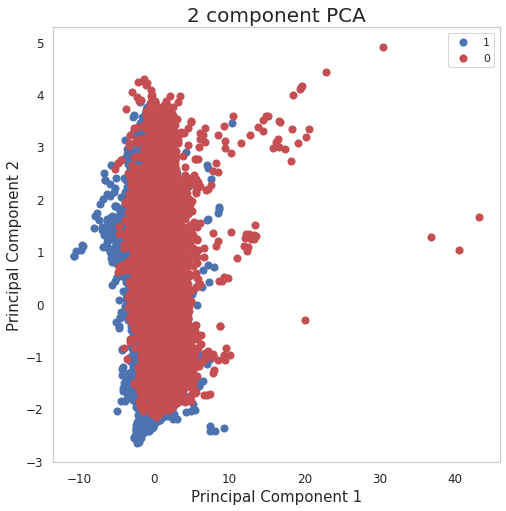

In [208]:
fig = plt.figure(figsize = (8,8)) # not working for 4 dimentions
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [1, 0]
colors = ['b', 'r']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['y'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'pc_1']
               , finalDf.loc[indicesToKeep, 'pc_2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [209]:
pca.explained_variance_ratio_

array([0.4018146 , 0.32304186])

In [210]:
# combine the new two attributes with the original dataset
df_uk_fin = pd.concat([finalDf, df_uk_3var], axis = 1)
df_uk_fin

,pc_1,pc_2,y,demand_INDO,wind_total,solar
timeblock,,,,,,
2017-01-01 00:00:00,-0.528806,-0.031950,1,27239.0,4891.0,0.0
2017-01-01 00:30:00,0.118386,0.119220,1,27814.0,4595.0,0.0
2017-01-01 01:00:00,-0.271481,0.139021,1,27453.0,4686.0,0.0
2017-01-01 01:30:00,-0.795801,-0.011947,1,26312.0,5439.0,0.0
2017-01-01 02:00:00,-0.839250,-0.019264,1,25289.0,5400.0,0.0
...,...,...,...,...,...,...
2019-12-31 21:30:00,-0.109031,0.450541,0,29172.0,5254.0,0.0
2019-12-31 22:00:00,-0.065824,0.490398,0,28126.0,5567.0,0.0
2019-12-31 22:30:00,-1.423609,0.299946,1,27407.0,5553.0,0.0


##### Random Forest

In [211]:
# # The following code crushes the session due to RAM
# from sklearn.ensemble import RandomForestRegressor
# model = RandomForestRegressor()
# df_uk_with_wind_inde = pd.get_dummies(df_uk_with_wind_inde)
# model.fit(df_uk_with_wind_inde,df_uk_with_wind['y'])

In [212]:
# features = df_uk_with_wind_inde.columns
# importances = model.feature_importances_
# indices = np.argsort(importances)[-4:]  # top 10 features
# plt.title('Feature Importances')
# plt.barh(range(len(indices)), importances[indices], color='b', align='center')
# plt.yticks(range(len(indices)), [features[i] for i in indices])
# plt.xlabel('Relative Importance')
# plt.show()

In [213]:
# # Use this code alternatively
# from sklearn.feature_selection import SelectFromModel
# feature = SelectFromModel(model)
# Fit = feature.fit(df_uk_with_wind_inde,df_uk_with_wind['y'])

#### Dimentionality reduction

In [214]:
# (demand_ITSDO, demand_INDO) (solar_for, solar) (wind_for_total, wind_total) (imbalance price, intraday price) (wind_for_total, wind_for_elexon)

In [215]:
# df_uk_4var = df_uk[['demand_INDO','intraday_price', 'wind_total', 'solar', 'y']]
# df_uk_4var

#### Feature engineering


##### 1. UK electricity demand (INDO): 15 min danach use before (including) t-2
##### 2. UK electricity demand (ITSDO): 15 min danach t-2
##### 3. UK wind power generation: 60 Min danach t-4
##### 4. UK solar generation: 60 Min danach t-4
##### 5. UK intraday price: 30 Min danach t-3
##### 6. UK intraday volume: 30 Min danach t-3
##### 7. UK imbalance price? 1 week? = t-336 



In [216]:
# Ideas for features:
# create new columns using + &
# create weekday & weekend dummies, season dummies

In [217]:
# Create t-2, t-3... columns
lags = range(2, 7)  # 5 lags

df_uk_fin = df_uk_fin.assign(**{ # Jeffrey: How does this work?
    '{} (t-{})'.format(col, t): df_uk_fin[col].shift(t)
    for t in lags
    for col in df_uk_fin[['demand_INDO']]
})

df_uk_fin.head()

,pc_1,pc_2,y,demand_INDO,wind_total,solar,demand_INDO (t-2),demand_INDO (t-3),demand_INDO (t-4),demand_INDO (t-5),demand_INDO (t-6)
timeblock,,,,,,,,,,,
2017-01-01 00:00:00,-0.528806,-0.031950,1,27239.0,4891.0,0.0,NaN,NaN,NaN,NaN,NaN
2017-01-01 00:30:00,0.118386,0.119220,1,27814.0,4595.0,0.0,NaN,NaN,NaN,NaN,NaN
2017-01-01 01:00:00,-0.271481,0.139021,1,27453.0,4686.0,0.0,27239.0,NaN,NaN,NaN,NaN
2017-01-01 01:30:00,-0.795801,-0.011947,1,26312.0,5439.0,0.0,27814.0,27239.0,NaN,NaN,NaN
2017-01-01 02:00:00,-0.839250,-0.019264,1,25289.0,5400.0,0.0,27453.0,27814.0,27239.0,NaN,NaN


In [218]:
lags = range(4, 9)  # 5 lags

df_uk_fin = df_uk_fin.assign(**{ # Jeffrey: How does this work?
    '{} (t-{})'.format(col, t): df_uk_fin[col].shift(t)
    for t in lags
    for col in df_uk_fin[['wind_total', 'solar']]
})

df_uk_fin.head()

,pc_1,pc_2,y,demand_INDO,wind_total,solar,demand_INDO (t-2),demand_INDO (t-3),demand_INDO (t-4),demand_INDO (t-5),demand_INDO (t-6),wind_total (t-4),solar (t-4),wind_total (t-5),solar (t-5),wind_total (t-6),solar (t-6),wind_total (t-7),solar (t-7),wind_total (t-8),solar (t-8)
timeblock,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,-0.528806,-0.031950,1,27239.0,4891.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 00:30:00,0.118386,0.119220,1,27814.0,4595.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 01:00:00,-0.271481,0.139021,1,27453.0,4686.0,0.0,27239.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 01:30:00,-0.795801,-0.011947,1,26312.0,5439.0,0.0,27814.0,27239.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 02:00:00,-0.839250,-0.019264,1,25289.0,5400.0,0.0,27453.0,27814.0,27239.0,NaN,NaN,4891.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [219]:
lags = range(3, 8)  # 5 lags

df_uk_fin = df_uk_fin.assign(**{ # Jeffrey: How does this work?
    '{} (t-{})'.format(col, t): df_uk_fin[col].shift(t)
    for t in lags
    for col in df_uk_fin[['pc_1', 'pc_2']]
})

df_uk_fin.head()

,pc_1,pc_2,y,demand_INDO,wind_total,solar,demand_INDO (t-2),demand_INDO (t-3),demand_INDO (t-4),demand_INDO (t-5),demand_INDO (t-6),wind_total (t-4),solar (t-4),wind_total (t-5),solar (t-5),wind_total (t-6),solar (t-6),wind_total (t-7),solar (t-7),wind_total (t-8),solar (t-8),pc_1 (t-3),pc_2 (t-3),pc_1 (t-4),pc_2 (t-4),pc_1 (t-5),pc_2 (t-5),pc_1 (t-6),pc_2 (t-6),pc_1 (t-7),pc_2 (t-7)
timeblock,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,-0.528806,-0.031950,1,27239.0,4891.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 00:30:00,0.118386,0.119220,1,27814.0,4595.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 01:00:00,-0.271481,0.139021,1,27453.0,4686.0,0.0,27239.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 01:30:00,-0.795801,-0.011947,1,26312.0,5439.0,0.0,27814.0,27239.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.528806,-0.03195,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 02:00:00,-0.839250,-0.019264,1,25289.0,5400.0,0.0,27453.0,27814.0,27239.0,NaN,NaN,4891.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.118386,0.11922,-0.528806,-0.03195,NaN,NaN,NaN,NaN,NaN,NaN


In [109]:
# # Create t-2, t-3... columns
# lags = range(3, 8)  # 5 lags

# df_uk_4var = df_uk_4var.assign(**{ # Jeffrey: How does this work?
#     '{} (t-{})'.format(col, t): df_uk_4var[col].shift(t)
#     for t in lags
#     for col in df_uk_4var[['intraday_price']] # 
# })

# df_uk_4var.head(12)

,demand_INDO,intraday_price,wind_total,solar,y,demand_INDO (t-2),demand_INDO (t-3),demand_INDO (t-4),demand_INDO (t-5),demand_INDO (t-6),wind_total (t-4),solar (t-4),wind_total (t-5),solar (t-5),wind_total (t-6),solar (t-6),wind_total (t-7),solar (t-7),wind_total (t-8),solar (t-8),intraday_price (t-3),intraday_price (t-4),intraday_price (t-5),intraday_price (t-6),intraday_price (t-7)
timeblock,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,27239.0,44.90,4891.0,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 00:30:00,27814.0,47.13,4595.0,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 01:00:00,27453.0,45.62,4686.0,0.0,1,27239.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 01:30:00,26312.0,44.05,5439.0,0.0,1,27814.0,27239.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.90,NaN,NaN,NaN,NaN
2017-01-01 02:00:00,25289.0,44.83,5400.0,0.0,1,27453.0,27814.0,27239.0,NaN,NaN,4891.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.13,44.90,NaN,NaN,NaN
2017-01-01 02:30:00,24616.0,45.51,5413.0,0.0,1,26312.0,27453.0,27814.0,27239.0,NaN,4595.0,0.0,4891.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,45.62,47.13,44.90,NaN,NaN
2017-01-01 03:00:00,23654.0,44.85,5594.0,0.0,1,25289.0,26312.0,27453.0,27814.0,27239.0,4686.0,0.0,4595.0,0.0,4891.0,0.0,NaN,NaN,NaN,NaN,44.05,45.62,47.13,44.90,NaN
2017-01-01 03:30:00,22806.0,42.80,5776.0,0.0,1,24616.0,25289.0,26312.0,27453.0,27814.0,5439.0,0.0,4686.0,0.0,4595.0,0.0,4891.0,0.0,NaN,NaN,44.83,44.05,45.62,47.13,44.90
2017-01-01 04:00:00,22234.0,42.33,5962.0,0.0,1,23654.0,24616.0,25289.0,26312.0,27453.0,5400.0,0.0,5439.0,0.0,4686.0,0.0,4595.0,0.0,4891.0,0.0,45.51,44.83,44.05,45.62,47.13


In [221]:
df_uk_fin = df_uk_fin.reindex(sorted(df_uk_fin.columns), axis=1)
df_uk_fin.head(12) # first available data point is 2017-01-01 04:00:00

,demand_INDO,demand_INDO (t-2),demand_INDO (t-3),demand_INDO (t-4),demand_INDO (t-5),demand_INDO (t-6),pc_1,pc_1 (t-3),pc_1 (t-4),pc_1 (t-5),pc_1 (t-6),pc_1 (t-7),pc_2,pc_2 (t-3),pc_2 (t-4),pc_2 (t-5),pc_2 (t-6),pc_2 (t-7),solar,solar (t-4),solar (t-5),solar (t-6),solar (t-7),solar (t-8),wind_total,wind_total (t-4),wind_total (t-5),wind_total (t-6),wind_total (t-7),wind_total (t-8),y
timeblock,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-01 04:00:00,22234.0,23654.0,24616.0,25289.0,26312.0,27453.0,-0.425948,-0.520072,-0.839250,-0.795801,-0.271481,0.118386,0.317257,0.076724,-0.019264,-0.011947,0.139021,0.119220,0.0,0.0,0.0,0.0,0.0,0.0,5962.0,5400.0,5439.0,4686.0,4595.0,4891.0,1
2017-01-01 04:30:00,21928.0,22806.0,23654.0,24616.0,25289.0,26312.0,-0.351472,-0.504062,-0.520072,-0.839250,-0.795801,-0.271481,0.360938,0.170869,0.076724,-0.019264,-0.011947,0.139021,0.0,0.0,0.0,0.0,0.0,0.0,5956.0,5413.0,5400.0,5439.0,4686.0,4595.0,1
2017-01-01 05:00:00,21726.0,22234.0,22806.0,23654.0,24616.0,25289.0,0.348149,-0.751550,-0.504062,-0.520072,-0.839250,-0.795801,0.489632,0.120651,0.170869,0.076724,-0.019264,-0.011947,0.0,0.0,0.0,0.0,0.0,0.0,5954.0,5594.0,5413.0,5400.0,5439.0,4686.0,0
2017-01-01 05:30:00,21597.0,21928.0,22234.0,22806.0,23654.0,24616.0,-0.478113,-0.425948,-0.751550,-0.504062,-0.520072,-0.839250,0.332572,0.317257,0.120651,0.170869,0.076724,-0.019264,0.0,0.0,0.0,0.0,0.0,0.0,6108.0,5776.0,5594.0,5413.0,5400.0,5439.0,1
2017-01-01 06:00:00,21887.0,21726.0,21928.0,22234.0,22806.0,23654.0,-0.732266,-0.351472,-0.425948,-0.751550,-0.504062,-0.520072,0.269996,0.360938,0.317257,0.120651,0.170869,0.076724,0.0,0.0,0.0,0.0,0.0,0.0,5917.0,5962.0,5776.0,5594.0,5413.0,5400.0,1
2017-01-01 06:30:00,22082.0,21597.0,21726.0,21928.0,22234.0,22806.0,-0.806547,0.348149,-0.351472,-0.425948,-0.751550,-0.504062,0.245122,0.489632,0.360938,0.317257,0.120651,0.170869,0.0,0.0,0.0,0.0,0.0,0.0,5881.0,5956.0,5962.0,5776.0,5594.0,5413.0,1
2017-01-01 07:00:00,22376.0,21887.0,21597.0,21726.0,21928.0,22234.0,-0.817725,-0.478113,0.348149,-0.351472,-0.425948,-0.751550,0.302298,0.332572,0.489632,0.360938,0.317257,0.120651,0.0,0.0,0.0,0.0,0.0,0.0,5814.0,5954.0,5956.0,5962.0,5776.0,5594.0,1
2017-01-01 07:30:00,22615.0,22082.0,21887.0,21597.0,21726.0,21928.0,-1.603319,-0.732266,-0.478113,0.348149,-0.351472,-0.425948,0.082317,0.269996,0.332572,0.489632,0.360938,0.317257,0.0,0.0,0.0,0.0,0.0,0.0,6044.0,6108.0,5954.0,5956.0,5962.0,5776.0,1
2017-01-01 08:00:00,23452.0,22376.0,22082.0,21887.0,21597.0,21726.0,-1.710504,-0.806547,-0.732266,-0.478113,0.348149,-0.351472,0.186070,0.245122,0.269996,0.332572,0.489632,0.360938,14.0,0.0,0.0,0.0,0.0,0.0,5919.0,5917.0,6108.0,5954.0,5956.0,5962.0,1


In [220]:
df_uk_fin = df_uk_fin.loc['2017-01-01 04:00:00': , :]
df_uk_fin.head()

,pc_1,pc_2,y,demand_INDO,wind_total,solar,demand_INDO (t-2),demand_INDO (t-3),demand_INDO (t-4),demand_INDO (t-5),demand_INDO (t-6),wind_total (t-4),solar (t-4),wind_total (t-5),solar (t-5),wind_total (t-6),solar (t-6),wind_total (t-7),solar (t-7),wind_total (t-8),solar (t-8),pc_1 (t-3),pc_2 (t-3),pc_1 (t-4),pc_2 (t-4),pc_1 (t-5),pc_2 (t-5),pc_1 (t-6),pc_2 (t-6),pc_1 (t-7),pc_2 (t-7)
timeblock,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-01 04:00:00,-0.425948,0.317257,1,22234.0,5962.0,0.0,23654.0,24616.0,25289.0,26312.0,27453.0,5400.0,0.0,5439.0,0.0,4686.0,0.0,4595.0,0.0,4891.0,0.0,-0.520072,0.076724,-0.839250,-0.019264,-0.795801,-0.011947,-0.271481,0.139021,0.118386,0.119220
2017-01-01 04:30:00,-0.351472,0.360938,1,21928.0,5956.0,0.0,22806.0,23654.0,24616.0,25289.0,26312.0,5413.0,0.0,5400.0,0.0,5439.0,0.0,4686.0,0.0,4595.0,0.0,-0.504062,0.170869,-0.520072,0.076724,-0.839250,-0.019264,-0.795801,-0.011947,-0.271481,0.139021
2017-01-01 05:00:00,0.348149,0.489632,0,21726.0,5954.0,0.0,22234.0,22806.0,23654.0,24616.0,25289.0,5594.0,0.0,5413.0,0.0,5400.0,0.0,5439.0,0.0,4686.0,0.0,-0.751550,0.120651,-0.504062,0.170869,-0.520072,0.076724,-0.839250,-0.019264,-0.795801,-0.011947
2017-01-01 05:30:00,-0.478113,0.332572,1,21597.0,6108.0,0.0,21928.0,22234.0,22806.0,23654.0,24616.0,5776.0,0.0,5594.0,0.0,5413.0,0.0,5400.0,0.0,5439.0,0.0,-0.425948,0.317257,-0.751550,0.120651,-0.504062,0.170869,-0.520072,0.076724,-0.839250,-0.019264
2017-01-01 06:00:00,-0.732266,0.269996,1,21887.0,5917.0,0.0,21726.0,21928.0,22234.0,22806.0,23654.0,5962.0,0.0,5776.0,0.0,5594.0,0.0,5413.0,0.0,5400.0,0.0,-0.351472,0.360938,-0.425948,0.317257,-0.751550,0.120651,-0.504062,0.170869,-0.520072,0.076724


In [239]:
df_uk_fin.shape

(52558, 31)

#### ACF & PACF to determine the window size for each variable

In [67]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

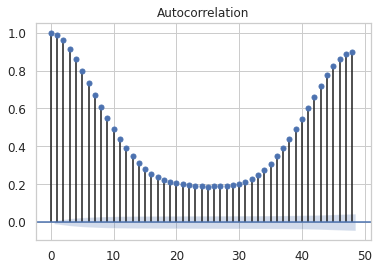

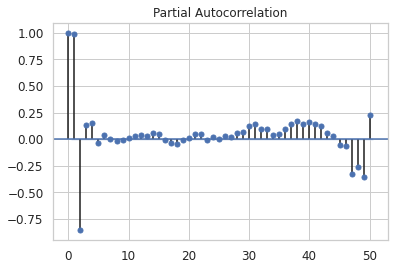

In [68]:
demand_ITSDO_acf = plot_acf(df_uk['demand_ITSDO']) # Why not showing year in the x axis?
plt.show(demand_ITSDO_acf)
demand_ITSDO_pacf = plot_pacf(df_uk['demand_ITSDO'], lags=50)
plt.show(demand_ITSDO_pacf)

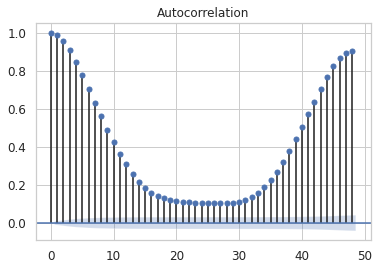

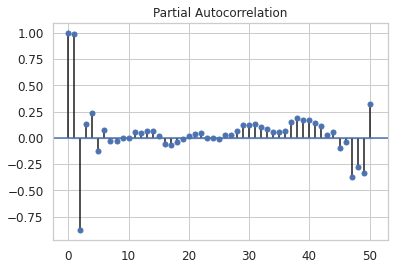

In [ ]:
demand_INDO_acf = plot_acf(df_uk['demand_INDO'])
plt.show(demand_INDO_acf)
demand_INDO_pacf = plot_pacf(df_uk['demand_INDO'], lags=50)
plt.show(demand_INDO_pacf)

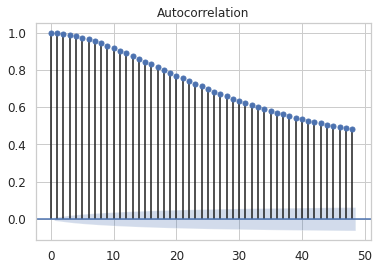

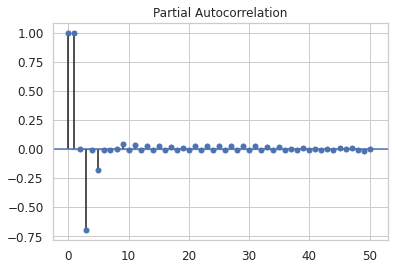

In [ ]:
wind_for_elexon_acf = plot_acf(df_uk['wind_for_elexon'])
plt.show(wind_for_elexon_acf)
wind_for_elexon_pacf = plot_pacf(df_uk['wind_for_elexon'], lags=50)
plt.show(wind_for_elexon_pacf)

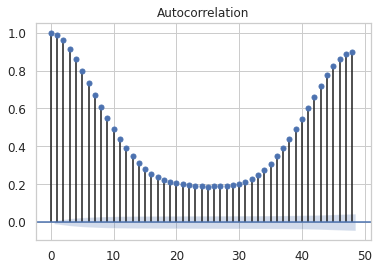

In [ ]:
demand_ITSDO_acf = plot_acf(df_uk['demand_ITSDO'])
plt.show()

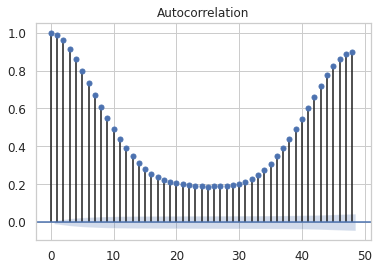

In [ ]:
demand_ITSDO_acf = plot_acf(df_uk['demand_ITSDO'])
plt.show()

#### Modeling - logsitic regression

In [230]:
# input 
x = df_uk_fin.iloc[:,:24].values
# output 
y = df_uk_fin.iloc[:, -1].values 

In [231]:
from sklearn.model_selection import train_test_split 
xtrain, xtest, ytrain, ytest = train_test_split( 
        x, y, test_size = 0.5, random_state = 0) 

In [232]:
standardized_x = preprocessing.scale(x)
standardized_x

array([[-1.13594188, -0.92652966, -0.78467125, ..., -0.64678097,
        -0.64678097, -0.64678097],
       [-1.18106223, -1.05156737, -0.92651763, ..., -0.64678097,
        -0.64678097, -0.64678097],
       [-1.21084756, -1.13590884, -1.05155477, ..., -0.64678097,
        -0.64678097, -0.64678097],
       ...,
       [-0.3731721 , -0.11289985,  0.09309539, ..., -0.64678097,
        -0.64678097, -0.64678097],
       [-0.48685768, -0.26713269, -0.11289151, ..., -0.64678097,
        -0.64678097, -0.64678097],
       [-0.55851941, -0.37314933, -0.26712364, ..., -0.64678097,
        -0.64678097, -0.64678097]])

In [233]:
from sklearn.linear_model import LogisticRegression 
classifier = LogisticRegression(random_state = 0)
classifier.fit(xtrain, ytrain) 

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [229]:
from sklearn.metrics import confusion_matrix 
cm = confusion_matrix(ytest, y_pred) 
  
print ("Confusion Matrix : \n", cm) 

NameError: ignored

In [ ]:
from sklearn.metrics import accuracy_score 
print ("Accuracy : ", accuracy_score(ytest, y_pred)) 

In [ ]:
# Visualizing the performance of our model
from matplotlib.colors import ListedColormap 
X_set, y_set = xtest, ytest 
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1,  
                               stop = X_set[:, 0].max() + 1, step = 0.01), 
                     np.arange(start = X_set[:, 1].min() - 1,  
                               stop = X_set[:, 1].max() + 1, step = 0.01)) 
  
plt.contourf(X1, X2, classifier.predict( 
             np.array([X1.ravel(), X2.ravel()]).T).reshape( 
             X1.shape), alpha = 0.75, cmap = ListedColormap(('red', 'green'))) 
  
plt.xlim(X1.min(), X1.max()) 
plt.ylim(X2.min(), X2.max()) 
  
for i, j in enumerate(np.unique(y_set)): 
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1], 
                c = ListedColormap(('red', 'green'))(i), label = j) 
      
plt.title('Classifier (Test set)') 
plt.xlabel('Age') 
plt.ylabel('Estimated Salary') 
plt.legend() 
plt.show() 

#### Modeling - LASSO

In [ ]:
# input 
X = df_uk_fin.iloc[:,:24].values
# output 
y = df_uk_fin.iloc[:, -1].values 

In [ ]:
standardized_x = preprocessing.scale(X)
standardized_x

In [234]:
# From https://github.com/krishnaik06/RegressionandLasso/blob/master/Lassoand%20Regression.ipynb
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
lasso=Lasso(max_iter=2000) # The tolerance for the optimization: if the updates are smaller than tol, the optimization code checks the dual gap for optimality and continues until it is smaller than tol.
# HELPPP: what deos that mean?
# HELPPP: How to make the y binary?
parameters={'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100]} # experiment with alpha
lasso_regressor=GridSearchCV(lasso,parameters,scoring='neg_mean_squared_error',cv=5)

lasso_regressor.fit(standardized_x,y)
print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2752.321639887928, tolerance: 1.0302131950720832
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2633.4131367691016, tolerance: 1.0092758240974293
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2770.832394197876, tolerance: 1.0063523973742914
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2800.557

{'alpha': 1e-08}
-0.13737341866796968


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3424.540909134409, tolerance: 1.2623040089044422
  positive)


In [235]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(standardized_x, y, test_size=0.3, random_state=0)

In [236]:
prediction_lasso = lasso_regressor.predict(x_test)

In [237]:
prediction_lasso # This is the prob of what the y can be. 0.63 -> y =1, 0.41 -> y=0

array([0.35881131, 0.75872866, 0.32668182, ..., 0.69710403, 0.87490188,
       0.14016326])

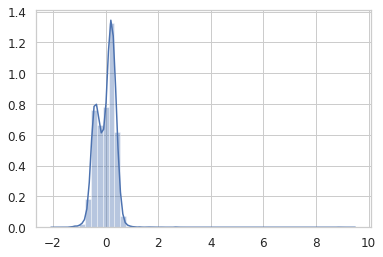

In [238]:
sns.distplot(y_test-prediction_lasso)

#### Modeling - Random Forest

In [ ]:
# Use numpy to convert to arrays

# Labels are the values we want to predict
labels = np.array(features['actual'])
# Remove the labels from the features
# axis 1 refers to the columns
features= features.drop('actual', axis = 1)
# Saving feature names for later use
feature_list = list(features.columns)
# Convert to numpy array
features = np.array(features)

#### SVR

In [118]:
# https://scikit-learn.org/stable/auto_examples/svm/plot_svm_regression.html

In [240]:
# input 
X = df_uk_fin.iloc[:,:29].values
# output 
y = df_uk_fin.iloc[:, -1].values 

In [241]:
standardized_x = preprocessing.scale(X)
standardized_x

array([[-1.13594188, -0.92652966, -0.78467125, ...,  0.23468164,
        -0.0400136 , -0.07320714],
       [-1.18106223, -1.05156737, -0.92651763, ...,  0.22045427,
         0.234684  , -0.04000995],
       [-1.21084756, -1.13590884, -1.05155477, ...,  0.22519673,
         0.22045664,  0.23468768],
       ...,
       [-0.3731721 , -0.11289985,  0.09309539, ...,  0.0679661 ,
         0.06505002, -0.04511721],
       [-0.48685768, -0.26713269, -0.11289151, ...,  0.11903869,
         0.06796846,  0.06505368],
       [-0.55851941, -0.37314933, -0.26712364, ...,  0.08365268,
         0.11904105,  0.06797212]])

In [ ]:
print(__doc__)

from sklearn.svm import SVR

# # #############################################################################
# # Generate sample data
# X = np.sort(5 * np.random.rand(40, 1), axis=0)
# y = np.sin(X).ravel()

# # #############################################################################
# # Add noise to targets
# y[::5] += 3 * (0.5 - np.random.rand(8))

# #############################################################################
# Fit regression model
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svr_lin = SVR(kernel='linear', C=100, gamma='auto')
svr_poly = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1,
               coef0=1)

# #############################################################################
# Look at the results
lw = 2

svrs = [svr_rbf, svr_lin, svr_poly]
kernel_label = ['RBF', 'Linear', 'Polynomial']
model_color = ['m', 'c', 'g']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10), sharey=True)
for ix, svr in enumerate(svrs):
    axes[ix].plot(X, svr.fit(X, y).predict(X), color=model_color[ix], lw=lw,
                  label='{} model'.format(kernel_label[ix]))
    axes[ix].scatter(X[svr.support_], y[svr.support_], facecolor="none",
                     edgecolor=model_color[ix], s=50,
                     label='{} support vectors'.format(kernel_label[ix]))
    axes[ix].scatter(X[np.setdiff1d(np.arange(len(X)), svr.support_)],
                     y[np.setdiff1d(np.arange(len(X)), svr.support_)],
                     facecolor="none", edgecolor="k", s=50,
                     label='other training data')
    axes[ix].legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
                    ncol=1, fancybox=True, shadow=True)

fig.text(0.5, 0.04, 'data', ha='center', va='center')
fig.text(0.06, 0.5, 'target', ha='center', va='center', rotation='vertical')
fig.suptitle("Support Vector Regression", fontsize=14)
plt.show()

Automatically created module for IPython interactive environment
